# **Exploring how COVID-19 altered people's reason to leave their jobs**

**By Shaotong Li**

When we conduct policy analysis, it can be useful to learn about the reasons why people leave their jobs. 

COVID-19 has changed everyone's daily behaviours, including the reasons for quitting work. Therefore, this project is trying to answer the following question:

How did COVID-19 affect people's reason for leaving a job.

The data has provided me 6 different catagories of quitting a job, including "Own illness or disability", "Personal or family reasons", "Going to school", "Dissatisfied", "Retired", and "Other reasons". I use ARIMA and Random forest to do time series prediction. Assuming predicted results are roughly the number of people who would have left work for each reason in the absence of COVID-19. And compare those figures with the actual numbers. My findings are:

1. The standard deviation of the number of people of every reason became greater during COVID-19.
2. "Own illness or disability" decreased as a reason to leave a job and "Other reasons" was increased during COVID-19.


**References:**
1.Statistics Canada. Table 14-10-0125-01  Reason for leaving job during previous year, monthly, unadjusted for seasonality (x 1,000)

## **Data Cleaning**
### **Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from sklearn import preprocessing
from sklearn import linear_model
import sklearn.model_selection
import sklearn.ensemble
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.core.pylabtools import figsize
import plotly.express as px  
import numpy as np


### **Import and Clean Data**

We only interested in the number of people of different kinds of reasons to leave a work.

In [ ]:
import pandas as pd 
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project/master.csv',index_col=0)
df = df.astype(float)
df = df.transpose()
df=df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
originaldf = df.iloc[:,35:41]

In [ ]:
originaldf

Master Data Set,Own illness or disability,Personal or family reasons,Going to school,Dissatisfied,Retired,Other reasons
2001-01-01,13600.0,14800.0,52700.0,17300.0,13800.0,27700.0
2001-02-01,17000.0,16300.0,52100.0,20800.0,13700.0,29100.0
2001-03-01,15300.0,21100.0,53900.0,15300.0,14700.0,28000.0
2001-04-01,13000.0,18500.0,49900.0,16500.0,14200.0,23800.0
2001-05-01,15900.0,18100.0,41000.0,18200.0,14000.0,22800.0
...,...,...,...,...,...,...
2021-05-01,12900.0,12800.0,46600.0,14700.0,37600.0,14100.0
2021-06-01,9400.0,11700.0,29600.0,13700.0,38300.0,17800.0
2021-07-01,7900.0,18000.0,22100.0,17400.0,37200.0,13900.0
2021-08-01,9700.0,22600.0,28100.0,23600.0,42500.0,16100.0


## **Data Visulization**
### **Original Data Time Series**

The number of people in different reasons from Jan, 2001 to Sep, 2021.

In [ ]:
fig = px.line()  
for i,n in enumerate(originaldf.columns):  
  fig.add_scatter(x=originaldf.index, y= originaldf[originaldf.columns[i]], name= originaldf.columns[i])  
fig

Y-axis shows the number of people, and X-axis shows the year and month of the data point. 
Note there is a cyclical pattern for some of the reasons, and they were modified during the pandemic.

### **Data Detrending and Scaling**

Now, let us preprocess data.
This is a time series data set, so we will have to remove the trend first.

In [ ]:
# Detrend: Remove linear trend for each series.
from scipy import signal
dfdetrend = pd.DataFrame()
for i in range(0,6):
  series1 = pd.Series(signal.detrend(originaldf.iloc[:,i]))
  dfdetrend.insert(i, originaldf.columns[i], series1, True)
dfdetrend.index=originaldf.index

Next, we scale the data set.

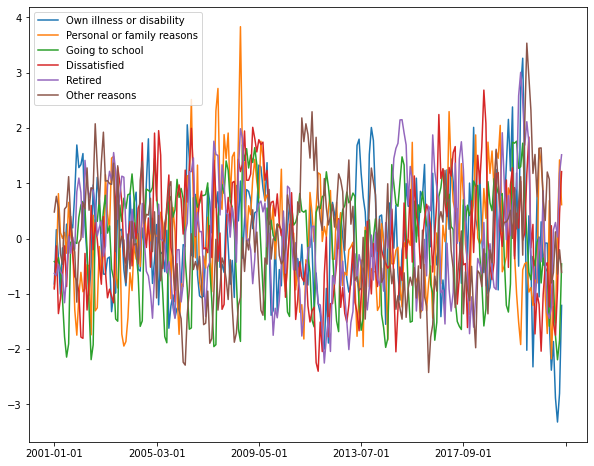

In [ ]:
# Scaling the data set.
scaler = preprocessing.StandardScaler().fit(dfdetrend)
scaled = scaler.transform(dfdetrend)
scaled
dfdetrendstd = pd.DataFrame(scaled, columns=dfdetrend.columns, index=dfdetrend.index)
dfdetrendstd.plot(figsize=(10,8))

As we can see, the data set provided has already been detrended and scaled.
 
Now we can start our quantitative analysis.

First, we are going to divide the data set into 2 periods. Define data before Jan 1st, 2020 "non-COVID" period and data after that "COVID" period.

Since we can roughly see a cyclical pattern for each of the reasons. Let's use the same month of these years to draw box plot for each month.

### **Constructing Box Plot**

In [ ]:
noncoviddf = dfdetrendstd.iloc[0:228]
coviddf = dfdetrendstd.iloc[228:249]

In [ ]:
# Define a function to filter out a month from "non-COVID" period. 
def getMonth(x,y):
  dfmonth = pd.DataFrame()
  t=-1
  for i in range (x,228,y):
    t=t + 1
    dfmonth[t] = noncoviddf.iloc[i]
  return dfmonth

# Define a function to filter out a month from "COVID" period. 
def getMonthcovid(x,y):
  dfmonth = pd.DataFrame()
  t=-1
  for i in range (x,20,y):
    t=t + 1
    dfmonth[t] = coviddf.iloc[i]
  return dfmonth

In [ ]:
Jandf = getMonth(0,12)
Febdf = getMonth(1,12)
Mardf = getMonth(2,12)
Aprdf = getMonth(3,12)
Maydf = getMonth(4,12)
Jundf = getMonth(5,12)
Juldf = getMonth(6,12)
Augdf = getMonth(7,12)
Sepdf = getMonth(8,12)
Octdf = getMonth(9,12)
Novdf = getMonth(10,12)
Decdf = getMonth(11,12)

CovidJandf = getMonthcovid(0,12)
CovidFebdf = getMonthcovid(1,12)
CovidMardf = getMonthcovid(2,12)
CovidAprdf = getMonthcovid(3,12)
CovidMaydf = getMonthcovid(4,12)
CovidJundf = getMonthcovid(5,12)
CovidJuldf = getMonthcovid(6,12)
CovidAugdf = getMonthcovid(7,12)
CovidSepdf = getMonthcovid(8,12)
CovidOctdf = getMonthcovid(9,12)
CovidNovdf = getMonthcovid(10,12)
CovidDecdf = getMonthcovid(11,12)

In [ ]:
def dfgenerator(x,y):
  x = pd.DataFrame()
  x["Jan"] = Jandf.loc[y]
  x["Feb"] = Febdf.loc[y]
  x["Mar"] = Mardf.loc[y]
  x["Apr"] = Aprdf.loc[y]
  x["May"] = Maydf.loc[y]
  x["Jun"] = Jundf.loc[y]
  x["Jul"] = Juldf.loc[y]
  x["Aug"] = Augdf.loc[y]
  x["Sep"] = Sepdf.loc[y]
  x["Oct"] = Octdf.loc[y]
  x["Nov"] = Novdf.loc[y]
  x["Dec"] = Decdf.loc[y]
  return x

# Define 6 Dataframes for each of the reason before COVID-19.
illnessdf = pd.DataFrame()
personaldf = pd.DataFrame()
schooldf = pd.DataFrame()
dissatisfieddf = pd.DataFrame()
retireddf = pd.DataFrame()
otherdf = pd.DataFrame()

illnessdf = dfgenerator(illnessdf,"Own illness or disability")
personaldf = dfgenerator(personaldf,"Personal or family reasons")
schooldf = dfgenerator(schooldf,"Going to school")
dissatisfieddf = dfgenerator(schooldf,"Dissatisfied")
retireddf = dfgenerator(schooldf,"Retired")
otherdf = dfgenerator(schooldf,"Other reasons")


In [ ]:
def dfcovidgenerator(x,y):
  x = pd.DataFrame()
  x["Jan"] = CovidJandf.loc[y]
  x["Feb"] = CovidFebdf.loc[y]
  x["Mar"] = CovidMardf.loc[y]
  x["Apr"] = CovidAprdf.loc[y]
  x["May"] = CovidMaydf.loc[y]
  x["Jun"] = CovidJundf.loc[y]
  x["Jul"] = CovidJuldf.loc[y]
  x["Aug"] = CovidAugdf.loc[y]
  x["Sep"] = CovidSepdf.loc[y]
  x["Oct"] = CovidOctdf.loc[y]
  x["Nov"] = CovidNovdf.loc[y]
  x["Dec"] = CovidDecdf.loc[y]
  return x

# Define 6 Dataframes for each of the reason during COVID-19.
illnesscoviddf = pd.DataFrame()
personalcoviddf = pd.DataFrame()
schoolcoviddf = pd.DataFrame()
dissatisfiedcoviddf = pd.DataFrame()
retiredcoviddf = pd.DataFrame()
othercoviddf = pd.DataFrame()

illnesscoviddf = dfcovidgenerator(illnesscoviddf,"Own illness or disability")
personalcoviddf = dfcovidgenerator(personalcoviddf,"Personal or family reasons")
schoolcoviddf = dfcovidgenerator(schoolcoviddf,"Going to school")
dissatisfiedcoviddf = dfcovidgenerator(dissatisfiedcoviddf,"Dissatisfied")
retiredcoviddf = dfcovidgenerator(retiredcoviddf,"Retired")
othercoviddf = dfcovidgenerator(othercoviddf,"Other reasons")



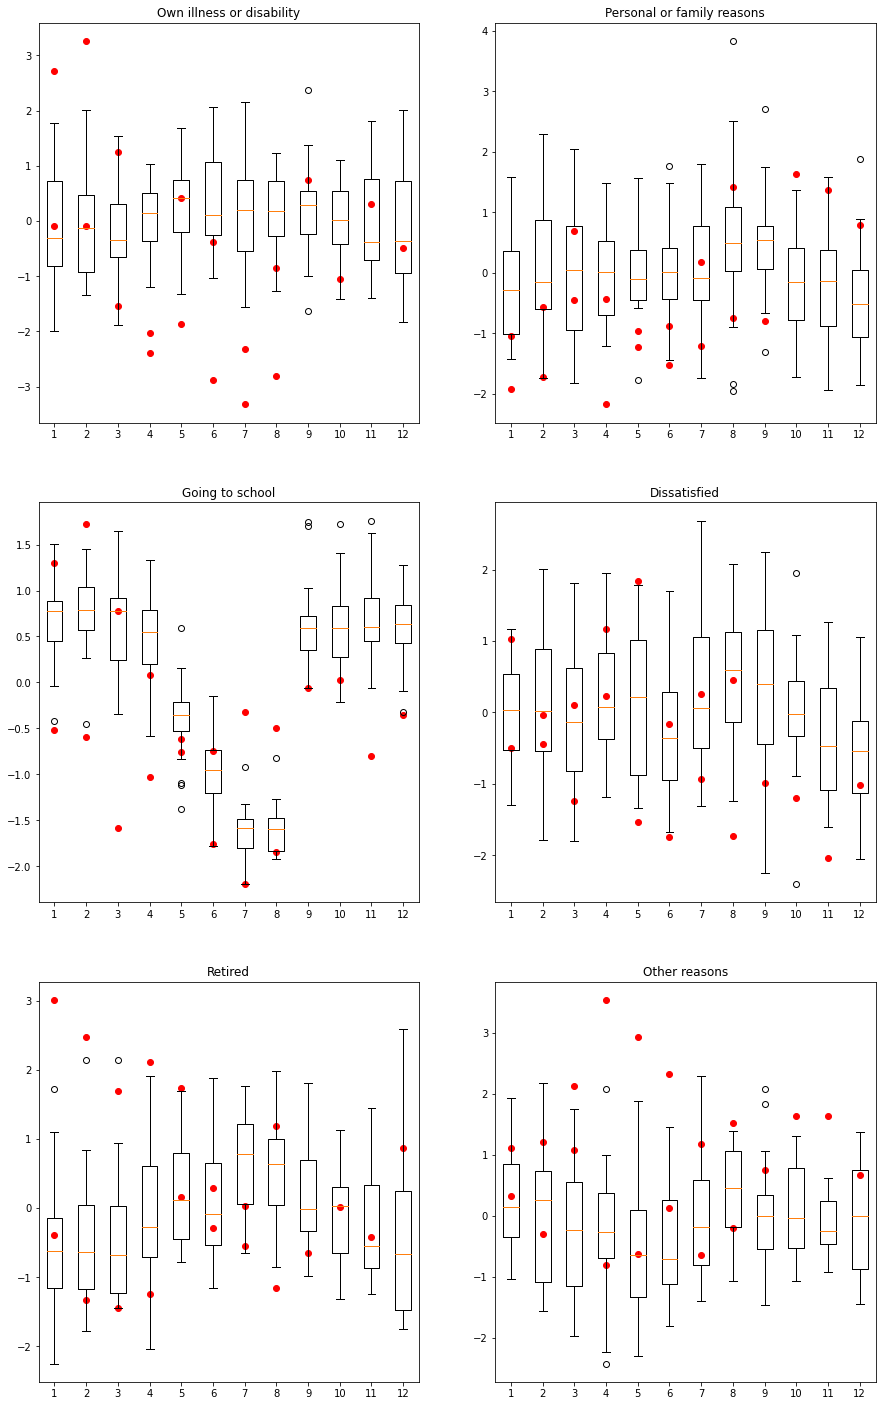

In [ ]:
fig = plt.figure(figsize=(15, 25))
getMonth(0,12)

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325) 
ax6 = fig.add_subplot(326)

ax1.title.set_text('Own illness or disability')
ax2.title.set_text('Personal or family reasons')
ax3.title.set_text('Going to school')
ax4.title.set_text('Dissatisfied')
ax5.title.set_text('Retired') 
ax6.title.set_text('Other reasons')

ax1.scatter(range(1,13),illnesscoviddf.iloc[0], color='red')
ax1.scatter(range(1,13),illnesscoviddf.iloc[1], color='red')
ax1.boxplot(illnessdf.transpose(), notch=None, vert=None, patch_artist=None, widths=None)

ax2.scatter(range(1,13),personalcoviddf.iloc[0], color='red')
ax2.scatter(range(1,13),personalcoviddf.iloc[1], color='red')
ax2.boxplot(personaldf.transpose(), notch=None, vert=None, patch_artist=None, widths=None)

ax3.scatter(range(1,13),schoolcoviddf.iloc[0], color='red')
ax3.scatter(range(1,13),schoolcoviddf.iloc[1], color='red')
ax3.boxplot(schooldf.transpose(), notch=None, vert=None, patch_artist=None, widths=None)

ax4.scatter(range(1,13),dissatisfiedcoviddf.iloc[0], color='red')
ax4.scatter(range(1,13),dissatisfiedcoviddf.iloc[1], color='red')
ax4.boxplot(dissatisfieddf.transpose(), notch=None, vert=None, patch_artist=None, widths=None)

ax5.scatter(range(1,13),retiredcoviddf.iloc[0], color='red')
ax5.scatter(range(1,13),retiredcoviddf.iloc[1], color='red')
ax5.boxplot(retireddf.transpose(), notch=None, vert=None, patch_artist=None, widths=None)

ax6.scatter(range(1,13),othercoviddf.iloc[0], color='red')
ax6.scatter(range(1,13),othercoviddf.iloc[1], color='red')
ax6.boxplot(otherdf.transpose(), notch=None, vert=None, patch_artist=None, widths=None)
plt.show()


The box plots were constructed by data before COVID-19 (Jan, 2001-Dec, 2019, 19 years) and red scattered dots are the data plotted with the data during COVID-19. (Jan, 2020 to Sep, 2021). Y-axis represents the real detreaded and scaled values and X-axis represents the month of each year.

We find during COVID-19, outliers appear in each of the reasons. Specifically, the number of people who:

1) Own illness or disability: Decreased from April to August during COVID-19.

2) Personal or family reasons: Increased from October to Deceber and decreased from January to February and from April to June during COVID-19.

3) Going to school: Decreased from September to December during COVID-19.

4) Dissatisfied and retired: No significant influence can be observed from box plot.

5) Other Reasons: Increased from April to June and from October to November during COVID-19.

### **Using ARIMA prediction to find the influence of COVID-19**

We are now trying to use ARIMA to make a prediction and compare the predicted values with actual values.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
stepwise_fit = auto_arima(dfdetrendstd.iloc[:,0], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=633.618, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=710.631, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=633.610, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=659.962, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=708.631, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=631.051, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=632.875, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=632.103, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=631.654, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=633.685, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=629.064, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=631.616, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=630.886, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=630.112, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=629.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -311.532
Date:                Sat, 25 Dec 2021   AIC                            629.064
Time:                        03:45:25   BIC                            639.616
Sample:                             0   HQIC                           633.312
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4524      0.056      8.129      0.000       0.343       0.561
ar.L2          0.1366      0.051      2.677      0.007       0.037       0.237
sigma2         0.7139      0.060     11.852      0.000       0.596       0.832
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.60
Prob(Q):                              0.95   Prob(JB):                         0.45
Heteroskedasticity (H):               2.02   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
train = dfdetrendstd.iloc[:-21]
test = dfdetrendstd.iloc[-21:]

model = ARIMA(train['Own illness or disability'],order=(2,0,0))
model = model.fit()
start = 0
end = len(train) + len(test) - 1
pred = model.predict(start=start, end = end, type="levels")
preddf = pd.DataFrame(pred)
preddf["test data"] = dfdetrendstd.iloc[:,0]

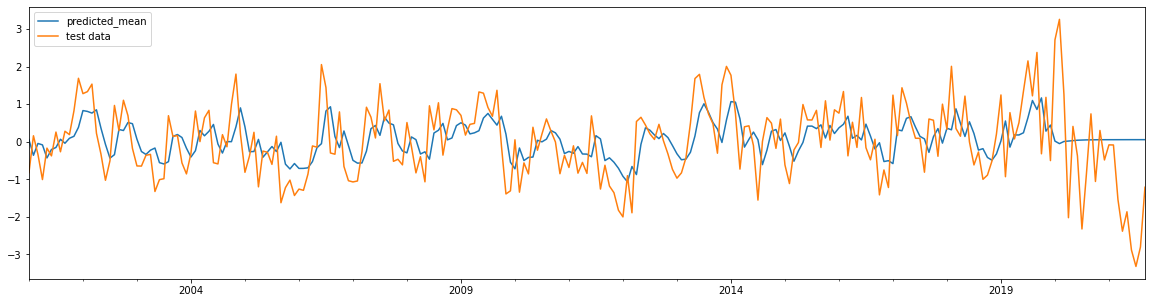

In [ ]:
# Check the fitness of the model.
preddf.plot(figsize=(20,5))

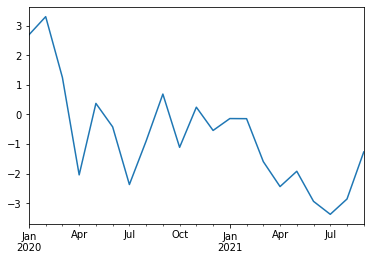

In [ ]:
# Compare the difference between real values and predicted values
dif = preddf[-21:]["test data"]-preddf[-21:]["predicted_mean"]
difdf = pd.DataFrame(dif)
arimaIllnessdf = difdf
difdf.plot(legend=False)

From ARIMA prediction, we find during COVID-19, the number of people who quit job with "Own illness or disability" was most likely lower than non-COVID period. Now, let's reapply this method to the 5 other reasons. 

In [ ]:
stepwise_fit = auto_arima(dfdetrendstd.iloc[:,1], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=622.202, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=710.631, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=621.692, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=648.429, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=708.631, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=621.044, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=621.773, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=620.283, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=620.172, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=620.854, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=634.160, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=618.172, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=646.429, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=619.692, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=618.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -306.086
Date:                Sat, 25 Dec 2021   AIC                            618.172
Time:                        03:45:31   BIC                            628.724
Sample:                             0   HQIC                           622.419
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7161      0.079      9.070      0.000       0.561       0.871
ma.L1         -0.2421      0.103     -2.360      0.018      -0.443      -0.041
sigma2         0.6832      0.058     11.793      0.000       0.570       0.797
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.85   Prob(JB):                         0.16
Heteroskedasticity (H):               1.16   Skew:                             0.27
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

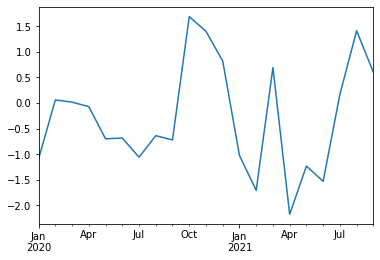

In [ ]:
train = dfdetrendstd.iloc[:-21]
test = dfdetrendstd.iloc[-21:]

model = ARIMA(train['Personal or family reasons'],order=(1,0,1))
model = model.fit()
start = 0
end = len(train) + len(test) - 1
pred = model.predict(start=start, end = end, type="levels")
preddf = pd.DataFrame(pred)
preddf["test data"] = dfdetrendstd.iloc[:,1]

dif = preddf[-21:]["test data"]-preddf[-21:]["predicted_mean"]
difdf = pd.DataFrame(dif)
arimaPersonal = difdf
arimaPersonal.plot(legend=False)

In [ ]:
stepwise_fit = auto_arima(dfdetrendstd.iloc[:,2], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=520.286, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=710.631, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=553.147, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=576.345, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=708.631, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=533.343, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=518.291, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=539.588, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=530.646, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=520.286, Time=0.60 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=523.715, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=521.658, Time=0.92 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=516.360, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=537.589, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=528.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -254.180
Date:                Sat, 25 Dec 2021   AIC                            516.360
Time:                        03:45:36   BIC                            530.429
Sample:                             0   HQIC                           522.023
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4445      0.113     12.824      0.000       1.224       1.665
ar.L2         -0.6862      0.079     -8.702      0.000      -0.841      -0.532
ma.L1         -0.6362      0.138     -4.604      0.000      -0.907      -0.365
sigma2         0.4491      0.045     10.014      0.000       0.361       0.537
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                57.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.86
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

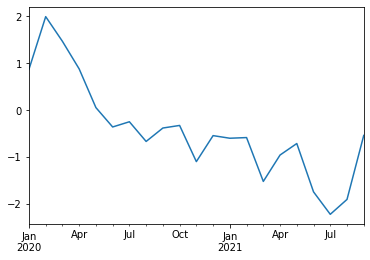

In [ ]:
train = dfdetrendstd.iloc[:-21]
test = dfdetrendstd.iloc[-21:]

model = ARIMA(train['Going to school'],order=(2,0,1))
model = model.fit()
start = 0
end = len(train) + len(test) - 1
pred = model.predict(start=start, end = end, type="levels")
preddf = pd.DataFrame(pred)
preddf["test data"] = dfdetrendstd.iloc[:,2]

dif = preddf[-21:]["test data"]-preddf[-21:]["predicted_mean"]
difdf = pd.DataFrame(dif)
arimaSchool = difdf
arimaSchool.plot(legend=False)

In [ ]:
stepwise_fit = auto_arima(dfdetrendstd.iloc[:,3], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=576.323, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=710.631, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=581.807, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=620.292, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=708.631, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=574.335, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=608.271, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=579.113, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=576.332, Time=0.47 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=587.415, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=575.101, Time=0.79 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=578.071, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=572.348, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=606.271, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=577.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -282.174
Date:                Sat, 25 Dec 2021   AIC                            572.348
Time:                        03:45:43   BIC                            586.418
Sample:                             0   HQIC                           578.011
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9227      0.046     20.103      0.000       0.833       1.013
ma.L1         -0.3809      0.085     -4.474      0.000      -0.548      -0.214
ma.L2         -0.2358      0.075     -3.152      0.002      -0.382      -0.089
sigma2         0.5631      0.054     10.519      0.000       0.458       0.668
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.97   Prob(JB):                         0.91
Heteroskedasticity (H):               1.40   Skew:                            -0.02
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

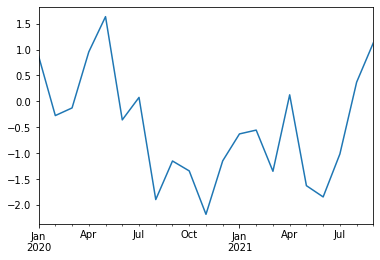

In [ ]:
train = dfdetrendstd.iloc[:-21]
test = dfdetrendstd.iloc[-21:]

model = ARIMA(train['Dissatisfied'],order=(1,0,2))
model = model.fit()
start = 0
end = len(train) + len(test) - 1
pred = model.predict(start=start, end = end, type="levels")
preddf = pd.DataFrame(pred)
preddf["test data"] = dfdetrendstd.iloc[:,3]

dif = preddf[-21:]["test data"]-preddf[-21:]["predicted_mean"]
difdf = pd.DataFrame(dif)
arimaDissatisfied = difdf
arimaDissatisfied.plot(legend=False)

In [ ]:
stepwise_fit = auto_arima(dfdetrendstd.iloc[:,4], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=505.823, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=710.631, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=505.999, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=585.609, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=708.631, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=508.067, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=509.796, Time=0.42 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=500.910, Time=1.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=507.315, Time=0.46 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=502.638, Time=1.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=502.796, Time=1.28 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=504.745, Time=0.53 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=508.216, Time=0.41 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=504.857, Time=1.50 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=498.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -243.456
Date:                Sat, 25 Dec 2021   AIC                            498.912
Time:                        03:45:57   BIC                            520.016
Sample:                             0   HQIC                           507.407
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0838      0.149     14.005      0.000       1.792       2.375
ar.L2         -1.7258      0.250     -6.890      0.000      -2.217      -1.235
ar.L3          0.5049      0.124      4.056      0.000       0.261       0.749
ma.L1         -1.3586      0.127    -10.677      0.000      -1.608      -1.109
ma.L2          0.8192      0.114      7.214      0.000       0.597       1.042
sigma2         0.4118      0.041     10.085      0.000       0.332       0.492
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.37
Prob(Q):                              0.87   Prob(JB):                         0.19
Heteroskedasticity (H):               1.90   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

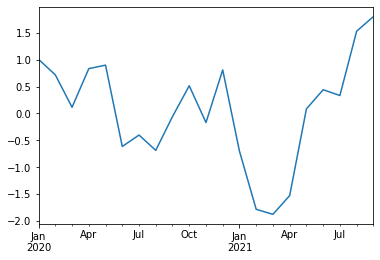

In [ ]:
train = dfdetrendstd.iloc[:-21]
test = dfdetrendstd.iloc[-21:]

model = ARIMA(train['Retired'],order=(3,0,2))
model = model.fit()
start = 0
end = len(train) + len(test) - 1
pred = model.predict(start=start, end = end, type="levels")
preddf = pd.DataFrame(pred)
preddf["test data"] = dfdetrendstd.iloc[:,4]

dif = preddf[-21:]["test data"]-preddf[-21:]["predicted_mean"]
difdf = pd.DataFrame(dif)
arimaRetired = difdf
arimaRetired.plot(legend=False)

In [ ]:
stepwise_fit = auto_arima(dfdetrendstd.iloc[:,5], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=520.440, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=710.631, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=527.396, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=612.512, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=708.631, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=519.086, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=558.983, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=517.717, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=518.545, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=516.639, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=518.575, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=520.508, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=514.639, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=525.396, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=516.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -254.320
Date:                Sat, 25 Dec 2021   AIC                            514.639
Time:                        03:46:00   BIC                            525.191
Sample:                             0   HQIC                           518.887
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5612      0.052     10.791      0.000       0.459       0.663
ar.L2          0.2231      0.056      3.998      0.000       0.114       0.332
sigma2         0.4500      0.041     11.057      0.000       0.370       0.530
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.86
Prob(Q):                              0.93   Prob(JB):                         0.24
Heteroskedasticity (H):               1.20   Skew:                             0.26
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

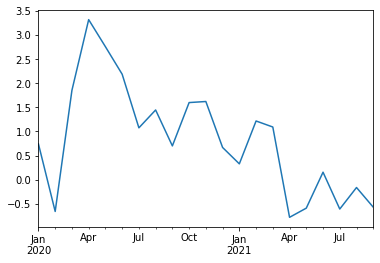

In [ ]:
train = dfdetrendstd.iloc[:-21]
test = dfdetrendstd.iloc[-21:]

model = ARIMA(train['Other reasons'],order=(2,0,0))
model = model.fit()
start = 0
end = len(train) + len(test) - 1
pred = model.predict(start=start, end = end, type="levels")
preddf = pd.DataFrame(pred)
preddf["test data"] = dfdetrendstd.iloc[:,5]

dif = preddf[-21:]["test data"]-preddf[-21:]["predicted_mean"]
difdf = pd.DataFrame(dif)
arimaOther = difdf
arimaOther.plot(legend=False)

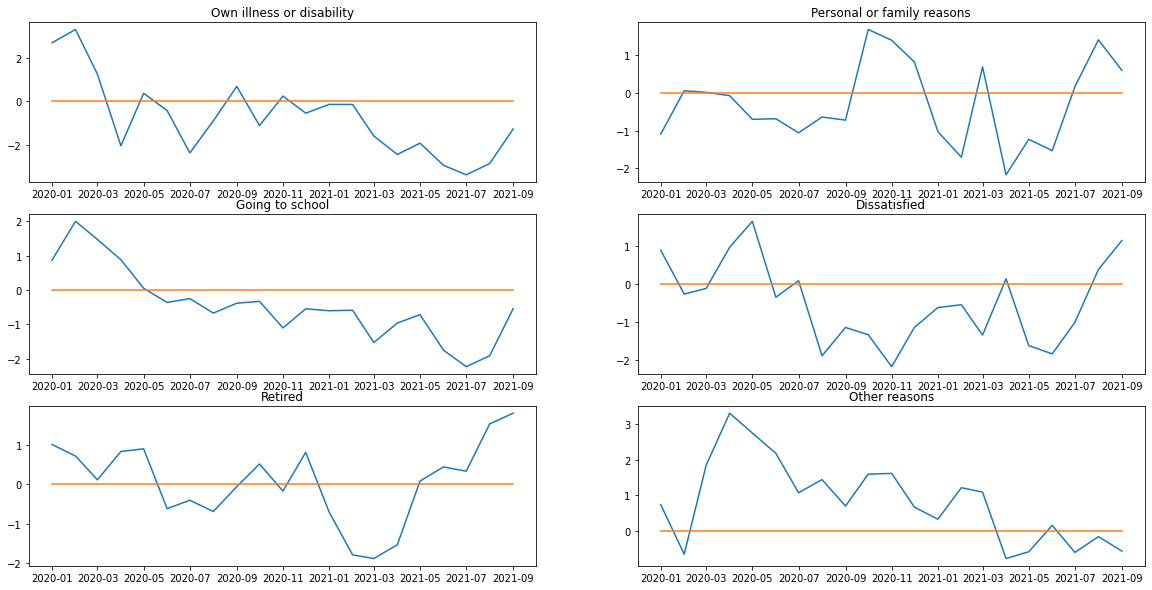

In [ ]:
fig = plt.figure(figsize=(20, 10))
getMonth(0,12)

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325) 
ax6 = fig.add_subplot(326)

ax1.title.set_text('Own illness or disability')
ax2.title.set_text('Personal or family reasons')
ax3.title.set_text('Going to school')
ax4.title.set_text('Dissatisfied')
ax5.title.set_text('Retired') 
ax6.title.set_text('Other reasons')

arimaIllnessdf["0"] = 0
arimaPersonal["0"] = 0
arimaSchool["0"] = 0
arimaDissatisfied["0"] = 0
arimaRetired["0"] = 0
arimaOther["0"] = 0

ax1.plot(arimaIllnessdf)
ax2.plot(arimaPersonal)
ax3.plot(arimaSchool)
ax4.plot(arimaDissatisfied)
ax5.plot(arimaRetired)
ax6.plot(arimaOther)
plt.show()

The blue curves in the graphs above represent the difference between real values and predicted values. The yellow curves stands for y=0. We may assume ARIMA predicted outcome is roughly the actual value to be observed if there were no COVID. So the difference between them shows the influence of COVID towards different variables.

As we can see, during COVID-19, less people tended to quit a job because of "Own illness or disability", "Going to School", "Dissatified", but more people tended to leave for "Other reasons".

### **Using Random Forest to find the influence of COVID-19**

Now, let's try to use Randon forest to predict number of people in each group in absense of COVID-19.

<Figure size 1440x720 with 0 Axes>

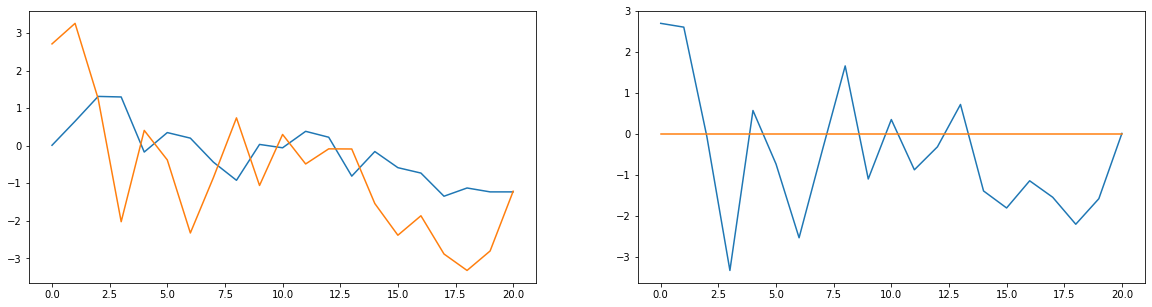

In [ ]:
fig = plt.figure(figsize=(20, 10))
dfshiftedIllness = pd.DataFrame()
dfshiftedIllness["t"] = dfdetrendstd.transpose().iloc[0]
dfshiftedIllness["t-1"] = dfdetrendstd.transpose().iloc[0].shift(+1)
dfshiftedIllness["t-2"] = dfdetrendstd.transpose().iloc[0].shift(+2)
dfshiftedIllness["t-3"] = dfdetrendstd.transpose().iloc[0].shift(+3)
dfshiftedIllness=dfshiftedIllness.dropna()

lin_model = LinearRegression()
model = RandomForestRegressor(n_estimators=100, max_features=3, random_state=1)
x1,x2,x3,y = np.array(dfshiftedIllness["t-1"]),np.array(dfshiftedIllness["t-2"]),np.array(dfshiftedIllness["t-3"]),np.array(dfshiftedIllness["t"])
x1,x2,x3,y = x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3), axis=1)

X_train,X_test,y_train,y_test=final_x[:-21],final_x[-21:],y[:-21],y[-21:]
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

pred = model.predict(X_test)

illnessRFdifdf = pd.DataFrame()
illnessRFdifdf["real - predicted"] = y_test.transpose()[0] - pred
illnessRFdifdf["0"] = 0
illnessRFdifdf.index = df


fig = plt.figure(figsize=(20, 5))
getMonth(0,12)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(pred)
ax1.plot(y_test)
ax2.plot(illnessRFdifdf)

# The plot on the left compares predicted values and real values, the other plot compared their differences with y=0 line.

From Random forest prediction, we find during COVID-19, the number of people who quit job with "Own illness or disability" was most likely lower than non-COVID period. Now, let's reapply this method to the 5 other reasons.

In [ ]:
#------Personal or family reasonsonal
dfshiftedPersonal = pd.DataFrame()
dfshiftedPersonal["t"] = dfdetrendstd.transpose().iloc[1]
dfshiftedPersonal["t-1"] = dfdetrendstd.transpose().iloc[1].shift(+1)
dfshiftedPersonal["t-2"] = dfdetrendstd.transpose().iloc[1].shift(+2)
dfshiftedPersonal["t-3"] = dfdetrendstd.transpose().iloc[1].shift(+3)
dfshiftedPersonal=dfshiftedPersonal.dropna()

lin_model = LinearRegression()
model = RandomForestRegressor(n_estimators=100, max_features=3, random_state=1)
x1,x2,x3,y = np.array(dfshiftedPersonal["t-1"]),np.array(dfshiftedPersonal["t-2"]),np.array(dfshiftedPersonal["t-3"]),np.array(dfshiftedPersonal["t"])
x1,x2,x3,y = x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3), axis=1)

X_train,X_test,y_train,y_test=final_x[:-21],final_x[-21:],y[:-21],y[-21:]
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

pred = model.predict(X_test)

personalRFdifdf = pd.DataFrame()
personalRFdifdf["real - predicted"] = y_test.transpose()[0] - pred
personalRFdifdf["0"] = 0

#------Going to School
dfshiftedSchool = pd.DataFrame()
dfshiftedSchool["t"] = dfdetrendstd.transpose().iloc[2]
dfshiftedSchool["t-1"] = dfdetrendstd.transpose().iloc[2].shift(+1)
dfshiftedSchool["t-2"] = dfdetrendstd.transpose().iloc[2].shift(+2)
dfshiftedSchool["t-3"] = dfdetrendstd.transpose().iloc[2].shift(+3)
dfshiftedSchool=dfshiftedSchool.dropna()

lin_model = LinearRegression()
model = RandomForestRegressor(n_estimators=100, max_features=3, random_state=1)
x1,x2,x3,y = np.array(dfshiftedSchool["t-1"]),np.array(dfshiftedSchool["t-2"]),np.array(dfshiftedSchool["t-3"]),np.array(dfshiftedSchool["t"])
x1,x2,x3,y = x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3), axis=1)

X_train,X_test,y_train,y_test=final_x[:-21],final_x[-21:],y[:-21],y[-21:]
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

pred = model.predict(X_test)

schoolRFdifdf = pd.DataFrame()
schoolRFdifdf["real - predicted"] = y_test.transpose()[0] - pred
schoolRFdifdf["0"] = 0


#------Dissatisfied
dfshiftedDissatisfied = pd.DataFrame()
dfshiftedDissatisfied["t"] = dfdetrendstd.transpose().iloc[3]
dfshiftedDissatisfied["t-1"] = dfdetrendstd.transpose().iloc[3].shift(+1)
dfshiftedDissatisfied["t-2"] = dfdetrendstd.transpose().iloc[3].shift(+2)
dfshiftedDissatisfied["t-3"] = dfdetrendstd.transpose().iloc[3].shift(+3)
dfshiftedDissatisfied=dfshiftedDissatisfied.dropna()

lin_model = LinearRegression()
model = RandomForestRegressor(n_estimators=100, max_features=3, random_state=1)
x1,x2,x3,y = np.array(dfshiftedDissatisfied["t-1"]),np.array(dfshiftedDissatisfied["t-2"]),np.array(dfshiftedDissatisfied["t-3"]),np.array(dfshiftedDissatisfied["t"])
x1,x2,x3,y = x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3), axis=1)

X_train,X_test,y_train,y_test=final_x[:-21],final_x[-21:],y[:-21],y[-21:]
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

pred = model.predict(X_test)

DissatisfiedRFdifdf = pd.DataFrame()
DissatisfiedRFdifdf["real - predicted"] = y_test.transpose()[0] - pred
DissatisfiedRFdifdf["0"] = 0


#------Retired
dfshiftedRetired = pd.DataFrame()
dfshiftedRetired["t"] = dfdetrendstd.transpose().iloc[4]
dfshiftedRetired["t-1"] = dfdetrendstd.transpose().iloc[4].shift(+1)
dfshiftedRetired["t-2"] = dfdetrendstd.transpose().iloc[4].shift(+2)
dfshiftedRetired["t-3"] = dfdetrendstd.transpose().iloc[4].shift(+3)
dfshiftedRetired=dfshiftedRetired.dropna()

lin_model = LinearRegression()
model = RandomForestRegressor(n_estimators=100, max_features=3, random_state=1)
x1,x2,x3,y = np.array(dfshiftedRetired["t-1"]),np.array(dfshiftedRetired["t-2"]),np.array(dfshiftedRetired["t-3"]),np.array(dfshiftedRetired["t"])
x1,x2,x3,y = x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3), axis=1)

X_train,X_test,y_train,y_test=final_x[:-21],final_x[-21:],y[:-21],y[-21:]
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

pred = model.predict(X_test)

RetiredRFdifdf = pd.DataFrame()
RetiredRFdifdf["real - predicted"] = y_test.transpose()[0] - pred
RetiredRFdifdf["0"] = 0


#------Other reasons
dfshiftedOther = pd.DataFrame()
dfshiftedOther["t"] = dfdetrendstd.transpose().iloc[5]
dfshiftedOther["t-1"] = dfdetrendstd.transpose().iloc[5].shift(+1)
dfshiftedOther["t-2"] = dfdetrendstd.transpose().iloc[5].shift(+2)
dfshiftedOther["t-3"] = dfdetrendstd.transpose().iloc[5].shift(+3)
dfshiftedOther=dfshiftedOther.dropna()

lin_model = LinearRegression()
model = RandomForestRegressor(n_estimators=100, max_features=3, random_state=1)
x1,x2,x3,y = np.array(dfshiftedOther["t-1"]),np.array(dfshiftedOther["t-2"]),np.array(dfshiftedOther["t-3"]),np.array(dfshiftedOther["t"])
x1,x2,x3,y = x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3), axis=1)

X_train,X_test,y_train,y_test=final_x[:-21],final_x[-21:],y[:-21],y[-21:]
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

pred = model.predict(X_test)

OtherRFdifdf = pd.DataFrame()
OtherRFdifdf["real - predicted"] = y_test.transpose()[0] - pred
OtherRFdifdf["0"] = 0



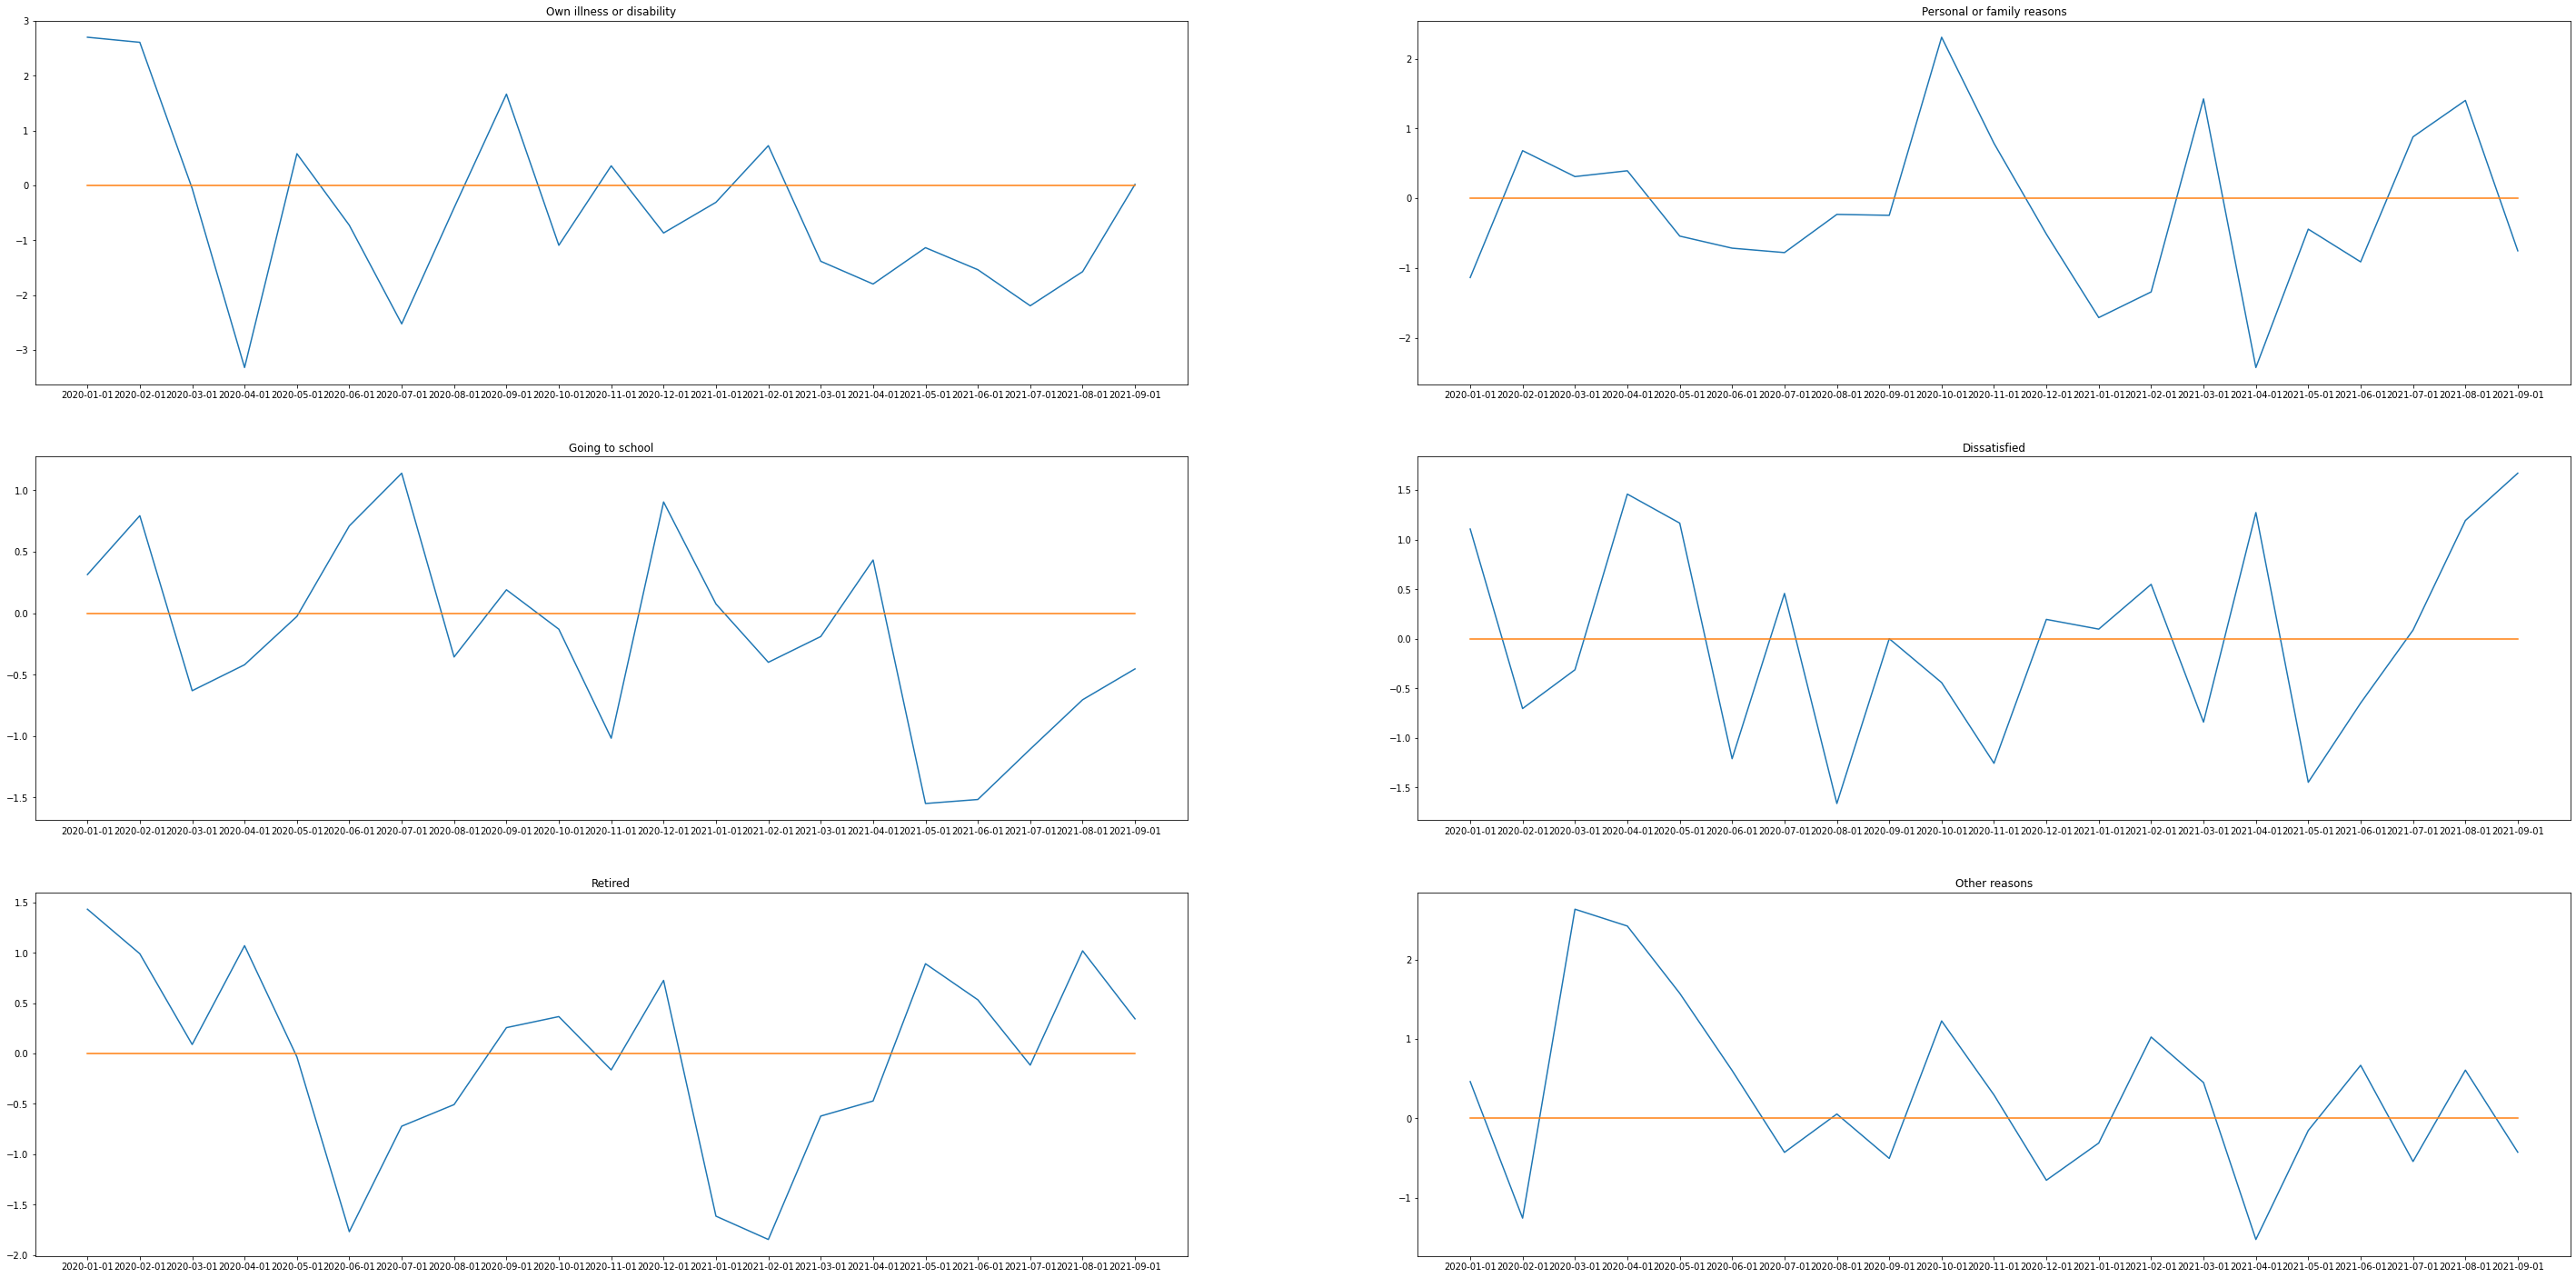

In [ ]:
fig = plt.figure(figsize=(50, 25))
getMonth(0,12)

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325) 
ax6 = fig.add_subplot(326)

ax1.title.set_text('Own illness or disability')
ax2.title.set_text('Personal or family reasons')
ax3.title.set_text('Going to school')
ax4.title.set_text('Dissatisfied')
ax5.title.set_text('Retired') 
ax6.title.set_text('Other reasons')

illnessRFdifdf.index = dfdetrendstd.iloc[-21:].index
personalRFdifdf.index = dfdetrendstd.iloc[-21:].index
schoolRFdifdf.index = dfdetrendstd.iloc[-21:].index
DissatisfiedRFdifdf.index = dfdetrendstd.iloc[-21:].index
RetiredRFdifdf.index = dfdetrendstd.iloc[-21:].index
OtherRFdifdf.index = dfdetrendstd.iloc[-21:].index

ax1.plot(illnessRFdifdf)
ax2.plot(personalRFdifdf)
ax3.plot(schoolRFdifdf)
ax4.plot(DissatisfiedRFdifdf)
ax5.plot(RetiredRFdifdf)
ax6.plot(OtherRFdifdf)
plt.show()

The blue curves in the graphs above represent the difference between real values and predicted values. The yellow curve stands for y = 0 line. We may assume Random forest predicted outcome is roughly the actual value to be observed in the absence of COVID-19. 

As we can see, during COVID-19, less people tended to quit a job because of "Own illness or disability" but more people tended to leave for "Other reasons".

## **Conclusion**
COVID-19 changed people's reason to leave a lot. However, it is not easy to conclude in which direction COVID affected the number of people for every reason.  It is relatively obvious that "Own illness or disability" decreased as a reason to leave a job and "Other reasons" experienced an increase during COVID-19. Although the direction of change may be ambiguous, we can still see that the standard deviation of the number of people of every reason became greater during COVID-19.